In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('train.csv')
df

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
...,...,...,...
31957,31958,0,ate @user isz that youuu?ðððððð...
31958,31959,0,to see nina turner on the airwaves trying to...
31959,31960,0,listening to sad songs on a monday morning otw...
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,..."


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [4]:
import re

In [5]:
def clean(text):
  #Replace all digits with space
  text = re.sub(r"[\d-]",'',text)
  # Remove Unicode characters
  text = re.sub(r'[^\x00-\x7F]+', '',text)
  #Remove retweets
  text = re.sub('user', '', text)
  # Remove urls
  text = re.sub(r'https?:\/\/[A-Za-z0-9\.\/]+', '', text)
  text = re.sub("[^a-zA-Z]", ' ',text)
  # Remove mentions:
  text = re.sub(r'@[A-Za-z0-9_]+', '', text)
  return text

df.tweet = df.tweet.apply(clean)

In [6]:
df

,id,label,tweet
0,1,0,when a father is dysfunctional and is so se...
1,2,0,thanks for lyft credit i can t use cause ...
2,3,0,bihday your majesty
3,4,0,model i love u take with u all the time in ...
4,5,0,factsguide society now motivation
...,...,...,...
31957,31958,0,ate isz that youuu
31958,31959,0,to see nina turner on the airwaves trying to...
31959,31960,0,listening to sad songs on a monday morning otw...
31960,31961,1,sikh temple vandalised in in calgary ws...


<AxesSubplot:>

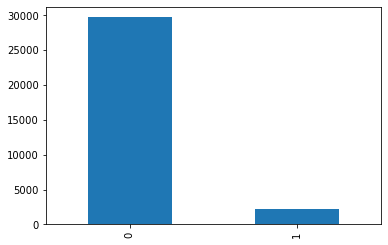

In [7]:
df['label'].value_counts().plot(kind='bar')

In [8]:
seq_len = 512
num_samples = len(df)

num_samples, seq_len

(31962, 512)

In [9]:
from transformers import BertTokenizer

In [10]:
# initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [11]:
# tokenize - this time returning Numpy tensors
tokens = tokenizer(df['tweet'].tolist(), max_length=seq_len, truncation=True,
                   padding='max_length', add_special_tokens=True,
                   return_tensors='np')

In [12]:
tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [13]:
tokens['input_ids']

array([[  101,  1165,   170, ...,     0,     0,     0],
       [  101,  5438,  1111, ...,     0,     0,     0],
       [  101, 16516,  1324, ...,     0,     0,     0],
       ...,
       [  101,  5578,  1106, ...,     0,     0,     0],
       [  101, 27466,  9862, ...,     0,     0,     0],
       [  101,  6243,  1128, ...,     0,     0,     0]])

In [14]:
tokens['attention_mask']

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [15]:
import numpy as np

In [16]:
with open('tweets_xids.npy', 'wb') as f:
    np.save(f, tokens['input_ids'])

with open('tweets_xmask.npy', 'wb') as f:
    np.save(f, tokens['attention_mask'])

In [17]:
del tokens

In [18]:
arr = df['label'].values
arr, arr.shape

(array([0, 0, 0, ..., 0, 1, 0], dtype=int64), (31962,))

In [19]:
arr.max()+1

2

In [20]:
labels = np.zeros((num_samples, arr.max()+1))
labels.shape

(31962, 2)

In [21]:
labels[np.arange(num_samples),arr] = 1
labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]])

In [22]:
with open('tweets_labels.npy', 'wb') as f:
    np.save(f, labels)

In [23]:
with open('tweets_xids.npy', 'rb') as f:
    Xids = np.load(f, allow_pickle=True)
with open('tweets_xmask.npy', 'rb') as f:
    Xmask = np.load(f, allow_pickle=True)
with open('tweets_labels.npy', 'rb') as f:
    labels = np.load(f, allow_pickle=True)

In [24]:
Xids.shape

(31962, 512)

In [25]:
labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]])

In [26]:
import tensorflow as tf

In [27]:
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

dataset.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(512,), dtype=tf.int32, name=None), TensorSpec(shape=(512,), dtype=tf.int32, name=None), TensorSpec(shape=(2,), dtype=tf.float64, name=None))>

In [28]:
def map_funct(ids, mask, labels):
    return {'input_ids': ids, 'attention_mask':mask},labels

dataset = dataset.map(map_funct)

In [29]:
dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(512,), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(512,), dtype=tf.int32, name=None)}, TensorSpec(shape=(2,), dtype=tf.float64, name=None))>

In [30]:
batch_size = 3

dataset = dataset.shuffle(3000).batch(batch_size, drop_remainder=True)

dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(3, 512), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(3, 512), dtype=tf.int32, name=None)}, TensorSpec(shape=(3, 2), dtype=tf.float64, name=None))>

In [31]:
#Split training and validation set
split = 0.9

In [32]:
size = int((Xids.shape[0] / batch_size) * split)
size

9588

In [33]:
train_set = dataset.take(size)
val_set = dataset.skip(size)

del dataset

In [34]:
train_set

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(3, 512), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(3, 512), dtype=tf.int32, name=None)}, TensorSpec(shape=(3, 2), dtype=tf.float64, name=None))>

In [35]:
tf.data.experimental.save(train_set, 'train')
tf.data.experimental.save(val_set, 'val')

Instructions for updating:
Use `tf.data.Dataset.save(...)` instead.


In [36]:
train_set.element_spec

({'input_ids': TensorSpec(shape=(3, 512), dtype=tf.int32, name=None),
  'attention_mask': TensorSpec(shape=(3, 512), dtype=tf.int32, name=None)},
 TensorSpec(shape=(3, 2), dtype=tf.float64, name=None))

In [37]:
val_set.element_spec == train_set.element_spec

True

In [38]:
ds = tf.data.experimental.load('train', element_spec=train_set.element_spec)

Instructions for updating:
Use `tf.data.Dataset.load(...)` instead.


In [39]:
from transformers import TFAutoModel

In [40]:
bert = TFAutoModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [41]:
# we can view the model using the summary method
bert.summary()

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


In [42]:
# two input layers, we ensure layer name variables match to dictionary keys in TF dataset
input_ids = tf.keras.layers.Input(shape=(512,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(512,), name='attention_mask', dtype='int32')

In [43]:
# we access the transformer model within our bert object using the bert attribute (eg bert.bert instead of bert)
embeddings = bert.bert(input_ids, attention_mask=mask)[0]  # access final activations with [0]

In [44]:
# convert bert embeddings into 2 output classes
x = tf.keras.layers.LSTM(32, dropout=.3, recurrent_dropout=.3, return_sequences=True)(embeddings)
x = tf.keras.layers.LSTM(16, dropout=.4, recurrent_dropout=.4, return_sequences=False)(x)
# normalize
x = tf.keras.layers.BatchNormalization()(x)
# output
x = tf.keras.layers.Dense(2, activation='relu')(x)
y = tf.keras.layers.Dense(2, activation='softmax', name='outputs')(x)

In [45]:
# initialize model
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

# (optional) freeze bert layer
model.layers[2].trainable = False

# print out model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

In [46]:
optimizer = tf.keras.optimizers.Adam(lr=1e-4, decay=1e-6)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

C:\Users\ReDI_NRW_765\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [47]:
element_spec = ({'input_ids': tf.TensorSpec(shape=(3, 512), dtype=tf.int32, name=None),
                 'attention_mask': tf.TensorSpec(shape=(3, 512), dtype=tf.int32, name=None)},
                tf.TensorSpec(shape=(3, 2), dtype=tf.float64, name=None))
                
# load the training and validation sets
train_ds = tf.data.experimental.load('train', element_spec=element_spec)
val_ds = tf.data.experimental.load('val', element_spec=element_spec)

# view the input format
train_ds.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(3, 512), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(3, 512), dtype=tf.int32, name=None)}, TensorSpec(shape=(3, 2), dtype=tf.float64, name=None))>

In [48]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=2
)

Epoch 1/2
9588/9588 [==============================] - 117336s 12s/step - loss: 0.2530 - accuracy: 0.9300 - val_loss: 0.2141 - val_accuracy: 0.9206
Epoch 2/2
9588/9588 [==============================] - 189858s 20s/step - loss: 0.1968 - accuracy: 0.9300 - val_loss: 0.2063 - val_accuracy: 0.9206


In [49]:
model.save('sentiment_model')

INFO:tensorflow:Assets written to: sentiment_model\assets


INFO:tensorflow:Assets written to: sentiment_model\assets


In [50]:
model = tf.keras.models.load_model('sentiment_model')

# view model architecture to confirm we have save and loaded correctly
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

In [51]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

def prep_data(text):
    tokens = tokenizer.encode_plus(text, max_length=512,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_token_type_ids=False,
                                   return_tensors='tf')
    # tokenizer returns int32 tensors, we need to return float64, so we use tf.cast
    return {'input_ids': tokens['input_ids'],
            'attention_mask': tokens['attention_mask']}

In [52]:
import pandas as pd

# so we can see full phrase
pd.set_option('display.max_colwidth', None)

dfa = pd.read_csv('test.csv')
dfa.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedication #willpower to find #newmaterialsâ¦
1,31964,@user #white #supremacists want everyone to see the new â #birdsâ #movie â and hereâs why
2,31965,safe ways to heal your #acne!! #altwaystoheal #healthy #healing!!
3,31966,"is the hp and the cursed child book up for reservations already? if yes, where? if no, when? ððð #harrypotter #pottermore #favorite"
4,31967,"3rd #bihday to my amazing, hilarious #nephew eli ahmir! uncle dave loves you and missesâ¦"


In [53]:
import re

In [54]:
def clean(text):
  #Replace all digits with space
  text = re.sub(r"[\d-]",'',text)
  # Remove Unicode characters
  text = re.sub(r'[^\x00-\x7F]+', '',text)
  #Remove retweets
  text = re.sub('user', '', text)
  # Remove urls
  text = re.sub(r'https?:\/\/[A-Za-z0-9\.\/]+', '', text)
  text = re.sub("[^a-zA-Z]", ' ',text)
  # Remove mentions:
  text = re.sub(r'@[A-Za-z0-9_]+', '', text)
  return text

dfa.tweet = dfa.tweet.apply(clean)

In [55]:
dfa

,id,tweet
0,31963,studiolife aislife requires passion dedication willpower to find newmaterials
1,31964,white supremacists want everyone to see the new birds movie and heres why
2,31965,safe ways to heal your acne altwaystoheal healthy healing
3,31966,is the hp and the cursed child book up for reservations already if yes where if no when harrypotter pottermore favorite
4,31967,rd bihday to my amazing hilarious nephew eli ahmir uncle dave loves you and misses
...,...,...
17192,49155,thought factory leftright polarisation trump uselections leadership politics brexit blm gt
17193,49156,feeling like a mermaid hairflip neverready formal wedding gown dresses mermaid
17194,49157,hillary campaigned today in ohio omg amp used words like assets amp liability never once did clinton say thee word radicalization
17195,49158,happy at work conference right mindset leads to cultureofdevelopment organizations work mindset


In [56]:
dfa['Label'] = None

for i, row in dfa.iterrows():
    # get token tensors
    tokens = prep_data(row['tweet'])
    # get probabilities
    probs = model.predict(tokens)
    # find argmax for winning class
    pred = np.argmax(probs)
    # add to dataframe
    dfa.at[i, 'Label'] = pred

dfa.head()

1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 4s 4s/step


1/1 [==============================] - 4s 4s/step


1/1 [==============================] - 4s 4s/step


1/1 [==============================] - 4s 4s/step


1/1 [==============================] - 5s 5s/step


1/1 [==============================] - 6s 6s/step


1/1 [==============================] - 6s 6s/step


1/1 [==============================] - 7s 7s/step


1/1 [==============================] - 16s 16s/step


1/1 [==============================] - 12s 12s/step


1/1 [==============================] - 8s 8s/step


1/1 [==============================] - 10s 10s/step


1/1 [==============================] - 38s 38s/step


1/1 [==============================] - 22s 22s/step


ResourceExhaustedError: Graph execution error:

Detected at node 'model/bert/encoder/layer_._6/attention/self/MatMul' defined at (most recent call last):
    File "C:\Users\ReDI_NRW_765\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\ReDI_NRW_765\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\ReDI_NRW_765\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\ReDI_NRW_765\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\ReDI_NRW_765\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\ReDI_NRW_765\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\ReDI_NRW_765\anaconda3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\ReDI_NRW_765\anaconda3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\ReDI_NRW_765\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\ReDI_NRW_765\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "C:\Users\ReDI_NRW_765\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "C:\Users\ReDI_NRW_765\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
      await result
    File "C:\Users\ReDI_NRW_765\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "C:\Users\ReDI_NRW_765\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\ReDI_NRW_765\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\ReDI_NRW_765\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2863, in run_cell
      result = self._run_cell(
    File "C:\Users\ReDI_NRW_765\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2909, in _run_cell
      return runner(coro)
    File "C:\Users\ReDI_NRW_765\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\ReDI_NRW_765\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3106, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\ReDI_NRW_765\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3309, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\ReDI_NRW_765\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3369, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\ReDI_NRW_765\AppData\Local\Temp\ipykernel_8092\3534121439.py", line 7, in <cell line: 3>
      probs = model.predict(tokens)
    File "C:\Users\ReDI_NRW_765\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ReDI_NRW_765\anaconda3\lib\site-packages\keras\engine\training.py", line 2253, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "C:\Users\ReDI_NRW_765\anaconda3\lib\site-packages\keras\engine\training.py", line 2041, in predict_function
      return step_function(self, iterator)
    File "C:\Users\ReDI_NRW_765\anaconda3\lib\site-packages\keras\engine\training.py", line 2027, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\ReDI_NRW_765\anaconda3\lib\site-packages\keras\engine\training.py", line 2015, in run_step
      outputs = model.predict_step(data)
    File "C:\Users\ReDI_NRW_765\anaconda3\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
      return self(x, training=False)
    File "C:\Users\ReDI_NRW_765\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ReDI_NRW_765\anaconda3\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\ReDI_NRW_765\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ReDI_NRW_765\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\ReDI_NRW_765\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ReDI_NRW_765\anaconda3\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\ReDI_NRW_765\anaconda3\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\ReDI_NRW_765\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ReDI_NRW_765\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\ReDI_NRW_765\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ReDI_NRW_765\anaconda3\lib\site-packages\transformers\modeling_tf_utils.py", line 763, in run_call_with_unpacked_inputs
      Loads a shard from a sharded checkpoint file. Handles the missing keys and unexpected keys.
    File "C:\Users\ReDI_NRW_765\anaconda3\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 873, in call
      encoder_outputs = self.encoder(
    File "C:\Users\ReDI_NRW_765\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ReDI_NRW_765\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\ReDI_NRW_765\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ReDI_NRW_765\anaconda3\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 558, in call
      for i, layer_module in enumerate(self.layer):
    File "C:\Users\ReDI_NRW_765\anaconda3\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 564, in call
      layer_outputs = layer_module(
    File "C:\Users\ReDI_NRW_765\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ReDI_NRW_765\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\ReDI_NRW_765\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ReDI_NRW_765\anaconda3\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 474, in call
      self_attention_outputs = self.attention(
    File "C:\Users\ReDI_NRW_765\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ReDI_NRW_765\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\ReDI_NRW_765\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ReDI_NRW_765\anaconda3\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 390, in call
      self_outputs = self.self_attention(
    File "C:\Users\ReDI_NRW_765\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ReDI_NRW_765\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\ReDI_NRW_765\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ReDI_NRW_765\anaconda3\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 320, in call
      attention_scores = tf.matmul(query_layer, key_layer, transpose_b=True)
Node: 'model/bert/encoder/layer_._6/attention/self/MatMul'
OOM when allocating tensor with shape[1,12,512,512] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node model/bert/encoder/layer_._6/attention/self/MatMul}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_193749]